In [1]:
from IPython.display import clear_output
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import re

from tqdm import tqdm
import sys
import dropbox
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl
from amftrack.util.dbx import load_dbx
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
)
from amftrack.pipeline.development.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
    
)

%matplotlib widget
%load_ext autoreload
%autoreload 2
logging.basicConfig(stream=sys.stdout, level=logging.debug)
mpl.rcParams['figure.dpi'] = 200

print("import great succes!")
%reload_ext autoreload

/gpfs/home6/svstaalduine/AMF_project/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-01-16 15:58:29.624432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 15:58:29.918264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home6/svstaalduine/.local/lib/python3.9/site-packages/cv2/../../lib64:/sw/arch/Centos8/EB_production/2021/software/ZeroMQ/4.3.4-GCCcore-10.3.0/lib:

import great succes!


In [2]:
analysis_folder = "/gpfs/home6/svstaalduine/Analysis/CocoTransport/"
dropbox_address = "/DATA/CocoTransport/"
excel_address = "/Daan te Rietmole/SpeedCheck.xlx"

analysis_filter = "20230906_Plate310/"

In [24]:
%%time
# edgedata = glob.glob("/gpfs/home6/svstaalduine/Analysis/CocoTransport/20230906_Plate310/052/Img/*csv")
edgedata = glob.glob(analysis_folder+analysis_filter+"*/*/*.csv")
print(len(edgedata))
print(analysis_folder+analysis_filter+"*/*.csv")

122
/gpfs/home6/svstaalduine/Analysis/CocoTransport/20230906_Plate310/*/*.csv
CPU times: user 12.3 ms, sys: 13.8 ms, total: 26.2 ms
Wall time: 155 ms


In [5]:
df1 = pd.read_csv(edgedata[0])
print(df1)

   Unnamed: 0 edge_name  edge_length  straight_length  speed_max  speed_min  \
0           0  (42, 32)       56.580       128.663151   3.327353  -4.908571   
1           0  (36, 34)       38.226        67.764043   3.872896  -8.630762   
2           0  (38, 37)       36.846        64.754212   5.404884  -3.065106   

   speed_mean   flux_avg    flux_min    flux_max  ...  speed_left_std  \
0   -1.065626 -37.439931 -104.373233    6.689216  ...        0.135705   
1   -0.477179 -29.395631 -212.380507   75.073501  ...        1.148907   
2   -0.139231 -12.592427 -150.424889  161.980193  ...        0.139477   

   speed_right_std  coverage_left  coverage_right  coverage_tot  edge_width  \
0         0.545244       0.535230        0.069106      0.562331   10.001745   
1         0.198477       0.212194        0.162455      0.319294   11.849731   
2         0.529872       0.583437        0.468581      0.736579   11.646141   

   edge_xpos_1  edge_ypos_1  edge_xpos_2  edge_ypos_2  
0       1481.0   

In [25]:
%%time

list_of_dfs = []

interested_subdirectories = ['20230906_Plate310']
# Walk through the directory and its subdirectories
i=0
for root, dirs, files in os.walk(analysis_folder):
    if any(subdir in root for subdir in interested_subdirectories):
        for file in files:
            if file.endswith('edges_data.csv'):
                
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                jsnpath = file_path[:-14]+'video_data.json'
                 
                with open(jsnpath, 'r') as file:
                    jason = json.load(file)
                 
                df.insert(1,"mode",jason['mode'])
                df.insert(2,"video_int",jason['video_int'])
                 
                list_of_dfs.append(df)
                    

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(list_of_dfs, ignore_index=True)

print(len(combined_df))
print(combined_df.iloc[0])

372
Unnamed: 0                  0
mode                        F
video_int                  68
edge_name              (8, 0)
edge_length            57.822
straight_length     67.072543
speed_max            3.385246
speed_min          -12.385488
speed_mean           -1.82421
flux_avg           -47.095546
flux_min          -228.659617
flux_max             2.183756
speed_left          -2.943182
speed_right          0.696347
speed_left_std       1.237948
speed_right_std       0.41069
coverage_left        0.113126
coverage_right       0.017422
coverage_tot         0.127924
edge_xpos_1            1110.0
edge_ypos_1            1256.0
edge_xpos_2             529.0
edge_ypos_2            2042.0
Name: 0, dtype: object
CPU times: user 1.09 s, sys: 1.43 s, total: 2.52 s
Wall time: 10.7 s


In [9]:
print(df.columns.tolist())

['Unnamed: 0', 'mode', 'video_int', 'edge_name', 'edge_length', 'straight_length', 'speed_max', 'speed_min', 'speed_mean', 'flux_avg', 'flux_min', 'flux_max', 'speed_left', 'speed_right', 'speed_left_std', 'speed_right_std', 'coverage_left', 'coverage_right', 'coverage_tot', 'edge_xpos_1', 'edge_ypos_1', 'edge_xpos_2', 'edge_ypos_2']


In [10]:
print(combined_df['edge_name'].iloc[2])

(8, 7)


In [26]:
%%time
sel_df = combined_df
# sel_df = combined_df[combined_df['speed_left']<=-4]
# sel_df = sel_df[sel_df['speed_right']>=4]
# sel_df = sel_df[sel_df['coverage_right']>=0.25]
# sel_df = sel_df[sel_df['coverage_left']>=0.25]
# sel_df = sel_df[sel_df['coverage_tot']>=0.7]
# sel_df = sel_df[sel_df['straight_length']<=200]


# sel_df = sel_df[sel_df['std_right']<=0.16]



BF_df = sel_df[sel_df['mode']=='BF']
FL_df = sel_df[sel_df['mode']=='F']

print(len(BF_df))
print(len(FL_df))

# print(BF_df[BF_df['edge_name']=='(24, 5)'])

139
233
CPU times: user 3.08 ms, sys: 66 µs, total: 3.15 ms
Wall time: 3.12 ms


In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(FL_df)

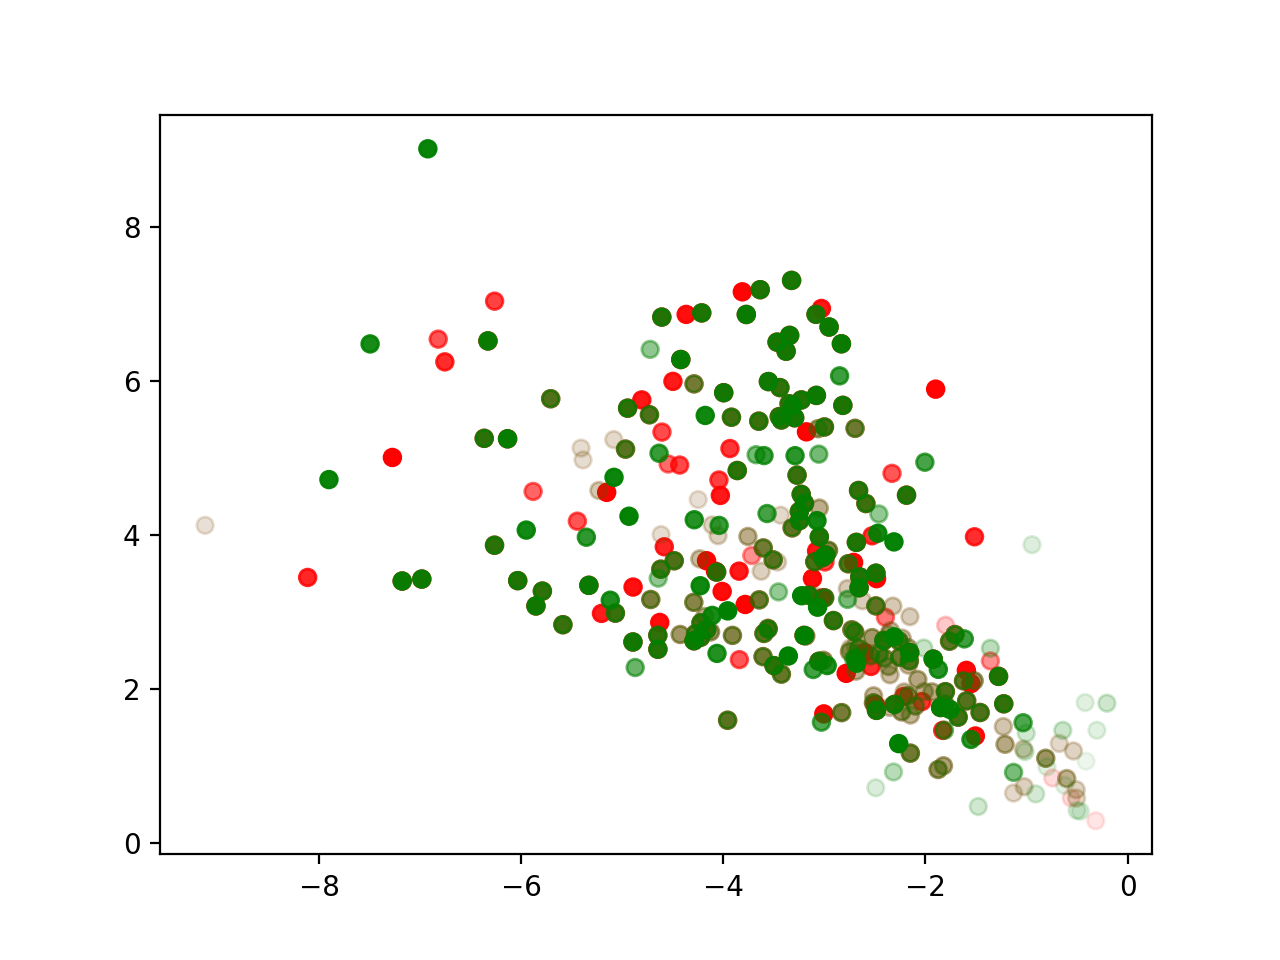

In [26]:
fig, ax = plt.subplots()
ax.scatter(combined_BF_df['speed_left'],combined_BF_df['speed_right'], alpha=combined_BF_df['coverage_tot'], color='green')
ax.scatter(combined_FL_df['speed_left'],combined_FL_df['speed_right'], alpha=combined_FL_df['coverage_tot'], color='red')
plt.show()

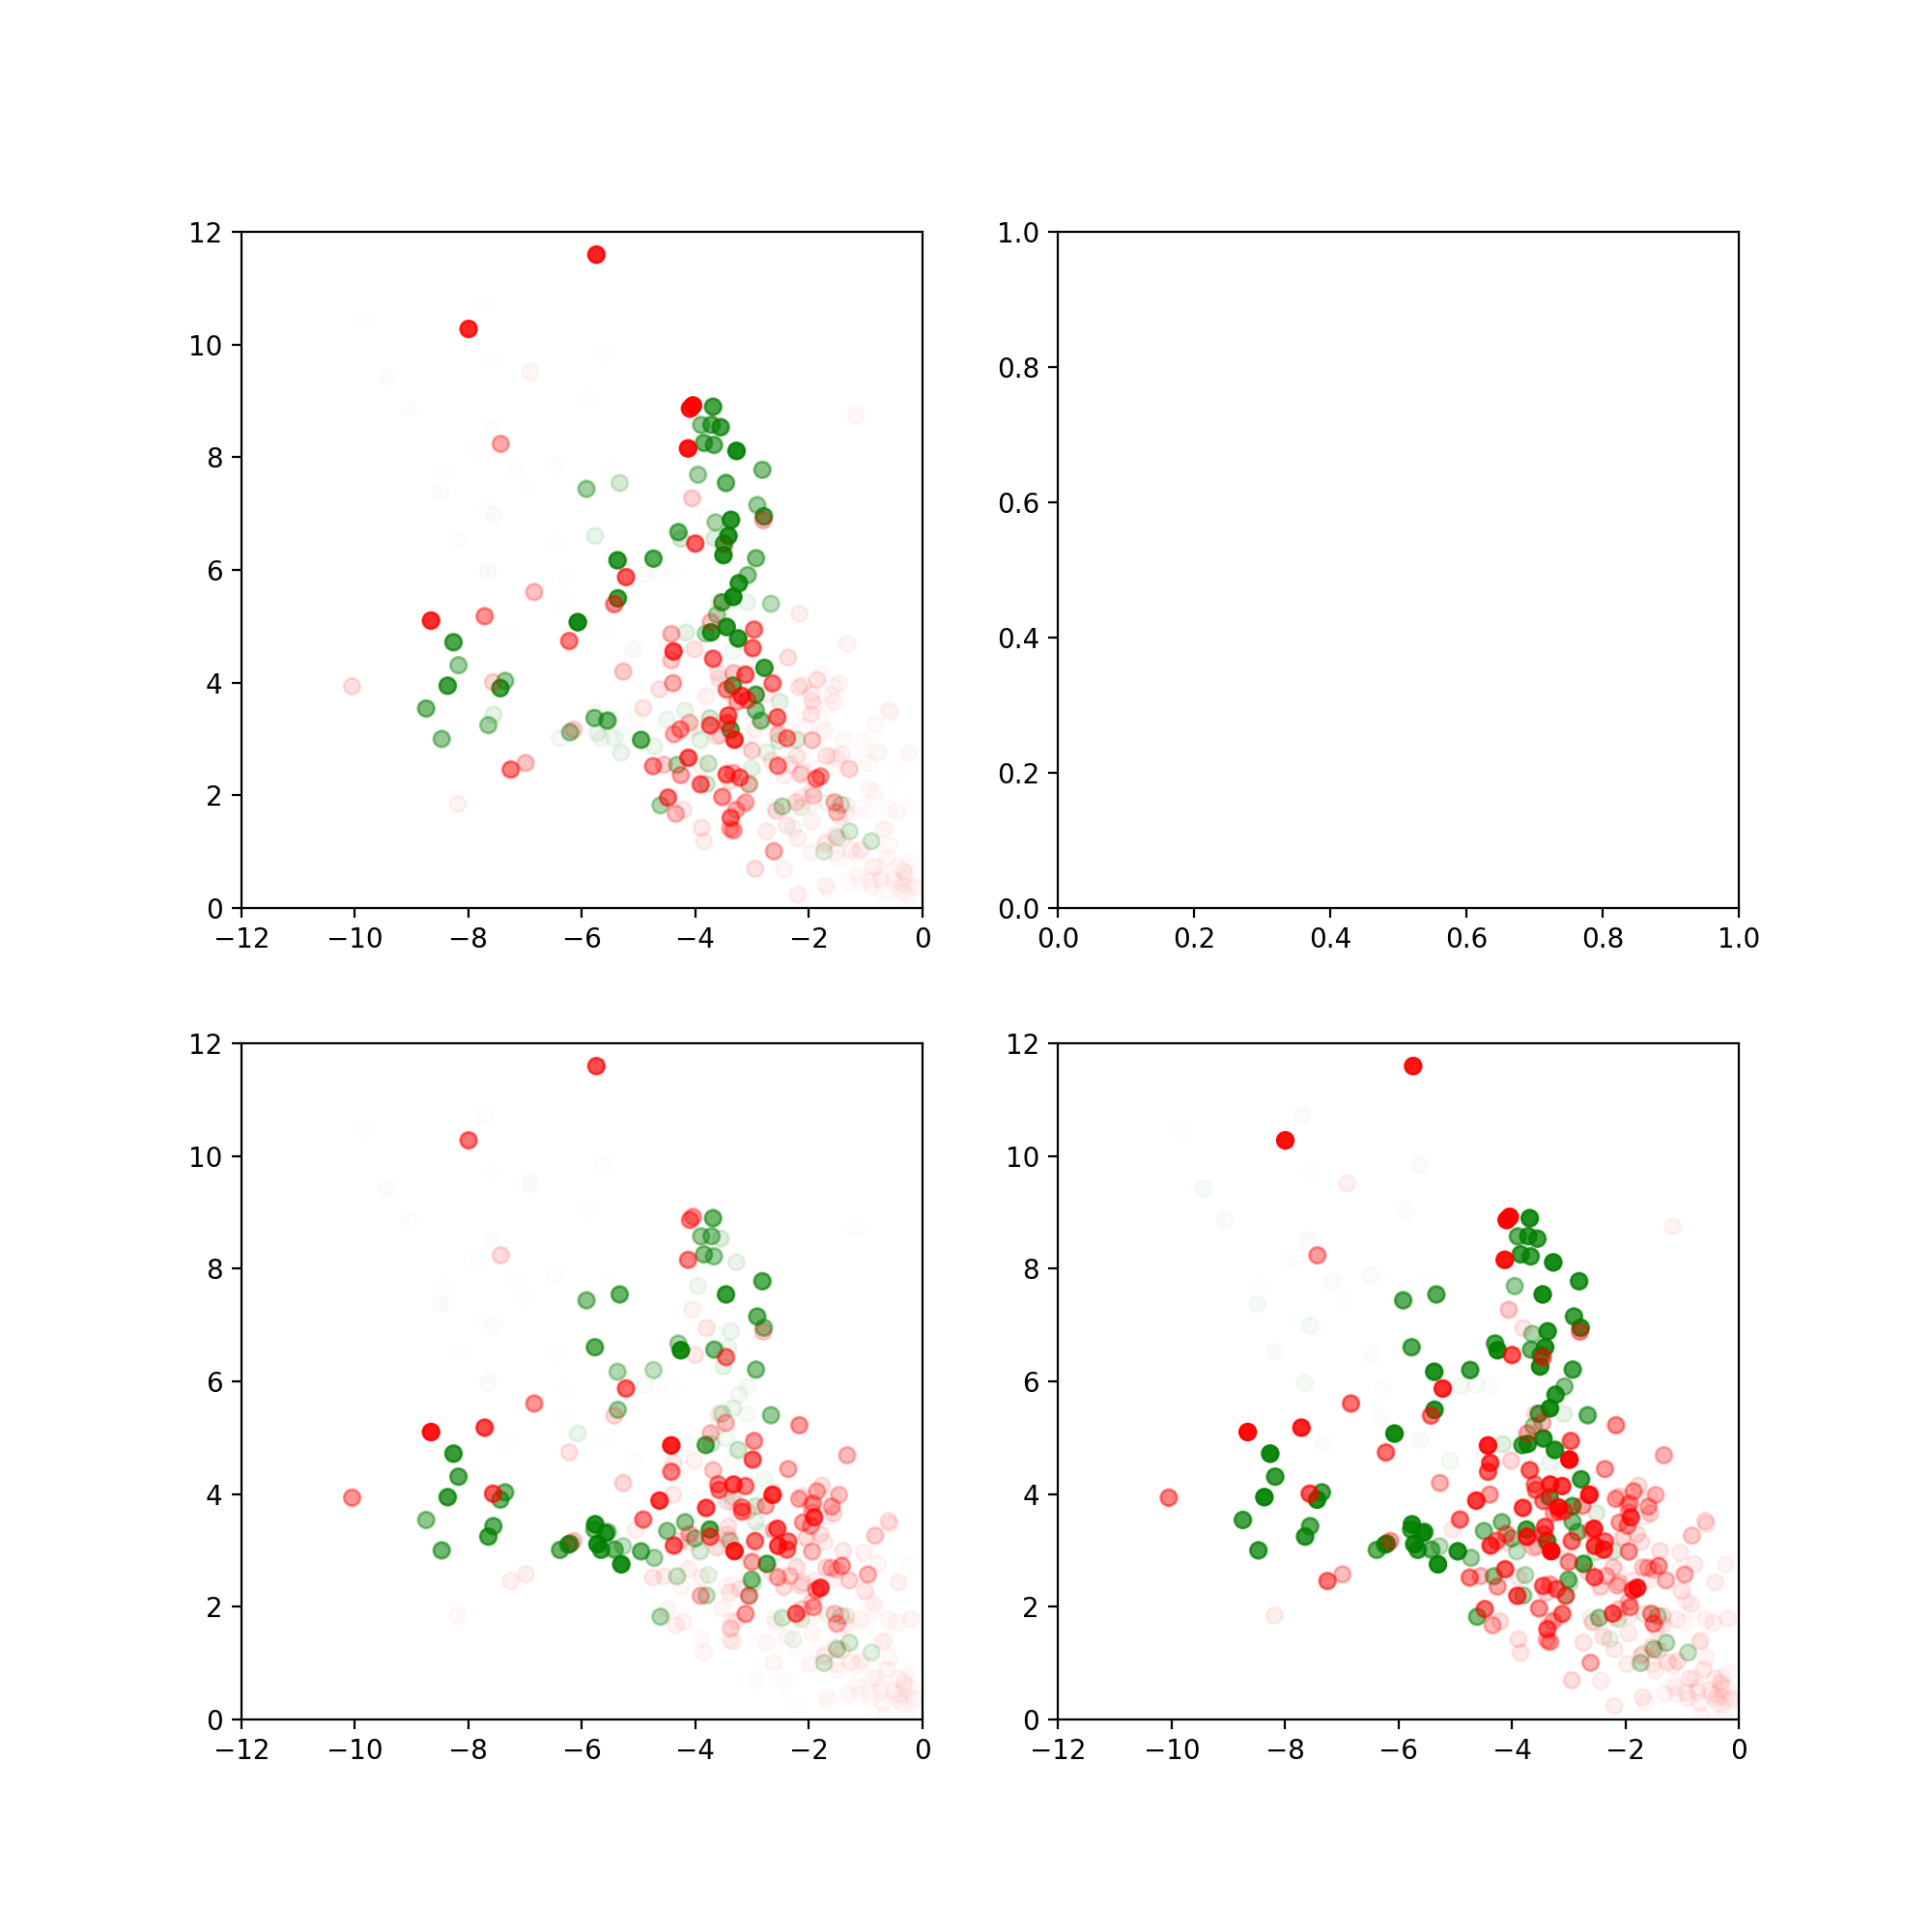

In [29]:
plt.close('all')
fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax[0][0].set_xlim(-12,0)
ax[0][0].set_ylim(0,12)
ax[1][0].set_xlim(-12,0)
ax[1][0].set_ylim(0,12)
ax[1][1].set_xlim(-12,0)
ax[1][1].set_ylim(0,12)
ax[0][0].scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=BF_df['coverage_left'], color='green')
ax[0][0].scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=FL_df['coverage_left'], color='red')
ax[1][0].scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=BF_df['coverage_right'], color='green')
ax[1][0].scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=FL_df['coverage_right'], color='red')
ax[1][1].scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=BF_df['coverage_tot'], color='green')
ax[1][1].scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=FL_df['coverage_tot'], color='red')
plt.show()

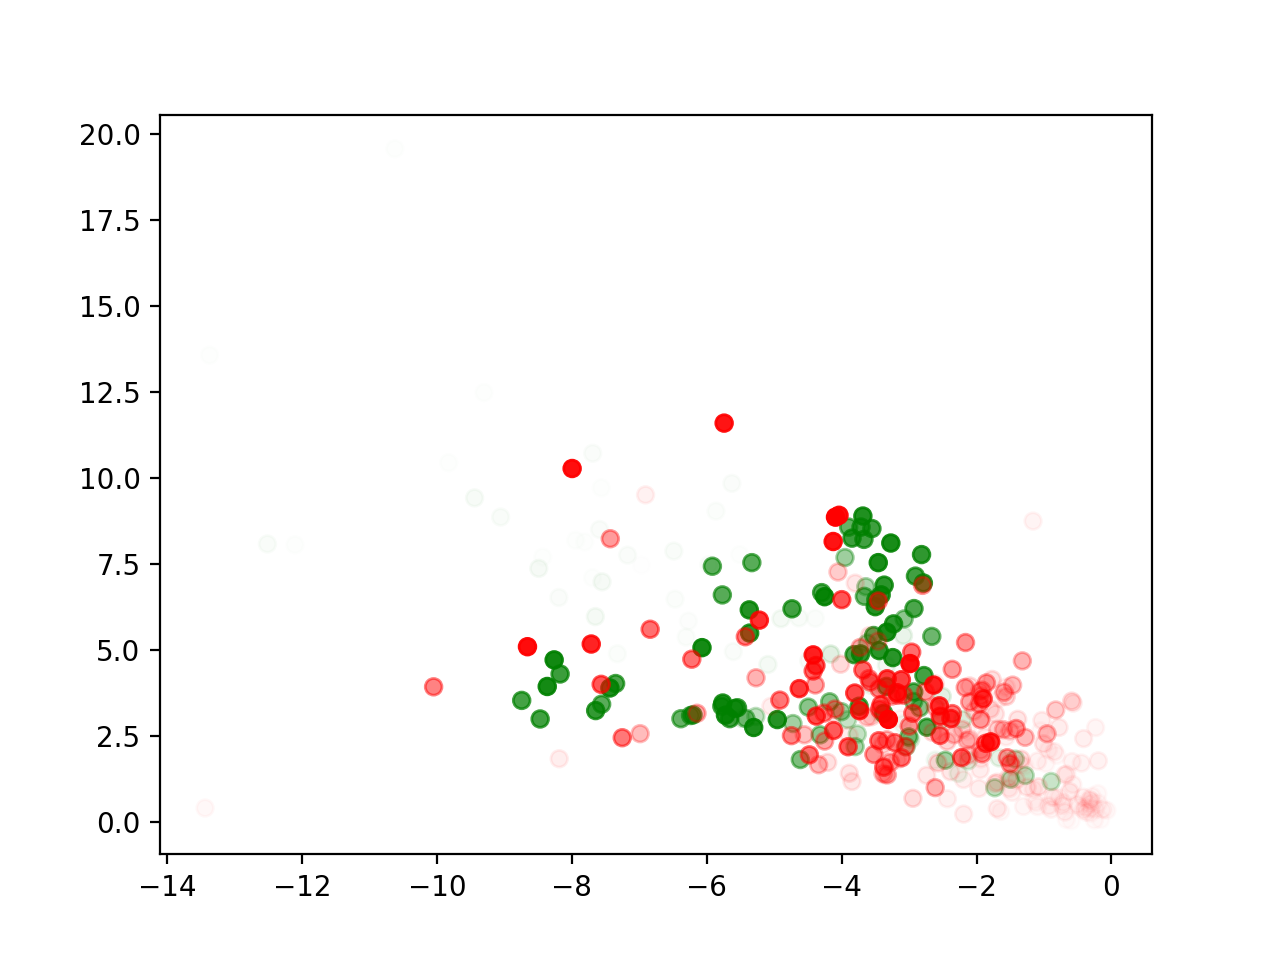

In [28]:
plt.close('all')
fig, ax = plt.subplots()
ax.scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=BF_df['coverage_tot'], color='green')
ax.scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=FL_df['coverage_tot'], color='red')
plt.show()